# Implementation of an Attention Model with Bi-LSTM

Python implementation of the attention model with bi-LSTM using Keras. 

Source paper can be found [here](https://arxiv.org/pdf/1409.0473.pdf). A high level diagram of the model can be seen [here](https://jscriptcoder.github.io/date-translator/attn_mechanism.png).





1. Generate the data for testing the efficiency using random numbers

In [1]:
from random import randint
from numpy import array
from numpy import argmax

In [2]:
# generate a sequence of random integers
def generate_sequence(length, n_unique):
    return [randint(0, n_unique-1) for _ in range(length)]

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
    return [argmax(vector) for vector in encoded_seq]

# prepare data for the LSTM
def get_pair(n_in, n_out, n_unique):
    # generate random sequence
    sequence_in = generate_sequence(n_in, n_unique)
    sequence_out = sequence_in[:n_out] + [0 for _ in range(n_in-n_out)]
    # one hot encode
    seq_input = one_hot_encode(sequence_in, n_unique)
    seq_output = one_hot_encode(sequence_out, n_unique)
    # reshape as 3D
    seq_input = seq_input.reshape((1, seq_input.shape[0], seq_input.shape[1]))
    seq_output = seq_output.reshape((1, seq_output.shape[0], seq_output.shape[1]))
    return seq_input,seq_output

2. Add the implementation of the model

In [3]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input,Bidirectional,LSTM,Dense,Activation,Dot,Multiply
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# need to write a custom softmax function as we want it to be used by attention weights & inputs
def softmax(x, axis=1):
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')

class AttentionModel:
    def __init__(self,**kwargs):
        self.__dict__.update(kwargs)
    
    def create(self):
        X = Input(shape=(self.pre_attention_output_units, self.input_features))
        activations = Bidirectional(LSTM(self.input_features,return_sequences=True),input_shape=self.input_shape)(X)
        outputs = []
        post_activation_LSTM = LSTM(self.input_features, return_sequences=True)
        post_activation_dense_layer = Dense(self.input_features, activation=softmax)
        self.activator = Activation(softmax,name='attention_weights')
        all_contexts=[]
        for i in range(self.output_cell_size):
            context = self.compute_context(input=activations)
            all_contexts.append(context)

        contexts = all_contexts[0]    
        for i in range(1,len(all_contexts)):
            contexts = tf.keras.layers.concatenate([contexts,all_contexts[i]],axis=1)

        s = post_activation_LSTM(contexts)
        out = post_activation_dense_layer(s)
        outputs.append(out)
        self.model = Model(inputs=X,outputs=outputs)
        opt = Adam(learning_rate=0.005,beta_1=0.9,beta_2=0.999,decay=0.01)
        self.model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        self.model.summary()
        plot_model(self.model, to_file='model.png', show_shapes=True)
  
    def compute_context(self,input):
        output_1 = Dense(self.hidden_dense_units, activation='tanh')(input)
        output_2 = Dense(1, activation='relu')(output_1)
        alphas = self.activator(output_2)
        context = Dot(axes=1)([alphas,input])
        return context
  
    def train(self,Xin,Yout,epochs,batch_size):
        self.model.fit(Xin, Yout, epochs=epochs, verbose=0, batch_size=batch_size)

    def predict(self,Xin):
        return self.model.predict(Xin)


3. Add the code for generating the input dataset.

In [4]:
# configure problem
n_features = 10
n_timesteps_in = 5
n_timesteps_out = 3
m = 5000
Tx = 5
hidden_dense_units = 10

X = np.zeros(shape=(m,Tx,n_features))
Y = np.zeros(shape=(m,Tx,n_features))

# generate new random sequence and push them to the dataset
for epoch in range(m):
    x,y = get_pair(n_timesteps_in,n_timesteps_out,n_features)
    X[epoch] = x
    Y[epoch] = y

4. Create and train the model.


In [5]:
attention_model = AttentionModel(m=m,input_shape=(m,Tx,n_features*2),pre_attention_output_units=n_timesteps_in,hidden_dense_units=hidden_dense_units,hidden_state_size_LSTM=n_timesteps_in,output_cell_size=Tx,input_features=n_features)
attention_model.create()

# train the model
attention_model.train(X,Y,epochs=5000,batch_size=5000)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5, 10)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 5, 20)        1680        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 5, 10)        210         bidirectional[0][0]              
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 5, 10)        210         bidirectional[0][0]              
______________________________________________________________________________________________

2021-08-03 12:33:33.876435: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-03 12:33:33.876583: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


50/50 [==============================] - 1s 6ms/step - loss: 2.2149 - accuracy: 0.4014
Epoch 2/3000
50/50 [==============================] - 0s 5ms/step - loss: 1.7752 - accuracy: 0.4637
Epoch 3/3000
50/50 [==============================] - 0s 5ms/step - loss: 1.5235 - accuracy: 0.4735
Epoch 4/3000
50/50 [==============================] - 0s 5ms/step - loss: 1.4333 - accuracy: 0.4914
Epoch 5/3000
50/50 [==============================] - 0s 6ms/step - loss: 1.3786 - accuracy: 0.5078
Epoch 6/3000
50/50 [==============================] - 0s 6ms/step - loss: 1.3455 - accuracy: 0.5177
Epoch 7/3000
50/50 [==============================] - 0s 5ms/step - loss: 1.3122 - accuracy: 0.5296
Epoch 8/3000
50/50 [==============================] - 0s 5ms/step - loss: 1.2768 - accuracy: 0.5441
Epoch 9/3000
50/50 [==============================] - 0s 5ms/step - loss: 1.2442 - accuracy: 0.5537
Epoch 10/3000
50/50 [==============================] - 0s 5ms/step - loss: 1.2209 - accuracy: 0.5705
Epoch 11/300

50/50 [==============================] - 0s 6ms/step - loss: 0.8353 - accuracy: 0.6807
Epoch 83/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.8427 - accuracy: 0.6784
Epoch 84/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.8365 - accuracy: 0.6825
Epoch 85/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.8351 - accuracy: 0.6833
Epoch 86/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.8317 - accuracy: 0.6818
Epoch 87/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.8292 - accuracy: 0.6832
Epoch 88/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.8268 - accuracy: 0.6831
Epoch 89/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.8286 - accuracy: 0.6796
Epoch 90/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.8316 - accuracy: 0.6834
Epoch 91/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.8281 - accuracy: 0.6808
Epoc

50/50 [==============================] - 0s 5ms/step - loss: 0.7670 - accuracy: 0.6964
Epoch 163/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.7643 - accuracy: 0.6996
Epoch 164/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.7658 - accuracy: 0.6974
Epoch 165/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.7635 - accuracy: 0.7003
Epoch 166/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.7634 - accuracy: 0.6995
Epoch 167/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.7577 - accuracy: 0.7029
Epoch 168/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.7625 - accuracy: 0.7004
Epoch 169/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.7565 - accuracy: 0.7030
Epoch 170/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.7570 - accuracy: 0.7008
Epoch 171/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.7605 - accuracy: 0.

50/50 [==============================] - 0s 5ms/step - loss: 0.7330 - accuracy: 0.7131
Epoch 243/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.7290 - accuracy: 0.7137
Epoch 244/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.7295 - accuracy: 0.7129
Epoch 245/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.7305 - accuracy: 0.7157
Epoch 246/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.7307 - accuracy: 0.7125
Epoch 247/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.7286 - accuracy: 0.7138
Epoch 248/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.7325 - accuracy: 0.7127
Epoch 249/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.7272 - accuracy: 0.7122
Epoch 250/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.7309 - accuracy: 0.7139
Epoch 251/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.7266 - accuracy: 0.

50/50 [==============================] - 0s 5ms/step - loss: 0.7097 - accuracy: 0.7293
Epoch 323/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.7067 - accuracy: 0.7310
Epoch 324/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.7056 - accuracy: 0.7271
Epoch 325/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.7080 - accuracy: 0.7288
Epoch 326/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.7025 - accuracy: 0.7287
Epoch 327/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.7037 - accuracy: 0.7303
Epoch 328/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.7055 - accuracy: 0.7237
Epoch 329/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.6993 - accuracy: 0.7292
Epoch 330/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.7034 - accuracy: 0.7308
Epoch 331/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.7016 - accuracy: 0.

50/50 [==============================] - 0s 6ms/step - loss: 0.6873 - accuracy: 0.7392
Epoch 403/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6880 - accuracy: 0.7395
Epoch 404/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6902 - accuracy: 0.7390
Epoch 405/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6889 - accuracy: 0.7380
Epoch 406/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6837 - accuracy: 0.7398
Epoch 407/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6888 - accuracy: 0.7378
Epoch 408/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6879 - accuracy: 0.7415
Epoch 409/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6864 - accuracy: 0.7406
Epoch 410/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6848 - accuracy: 0.7396
Epoch 411/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6857 - accuracy: 0.

50/50 [==============================] - 0s 5ms/step - loss: 0.6718 - accuracy: 0.7442
Epoch 483/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6734 - accuracy: 0.7463
Epoch 484/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6719 - accuracy: 0.7420
Epoch 485/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6724 - accuracy: 0.7442
Epoch 486/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6710 - accuracy: 0.7434
Epoch 487/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6692 - accuracy: 0.7451
Epoch 488/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6726 - accuracy: 0.7455
Epoch 489/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6739 - accuracy: 0.7463
Epoch 490/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6748 - accuracy: 0.7411
Epoch 491/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6694 - accuracy: 0.

50/50 [==============================] - 0s 5ms/step - loss: 0.6632 - accuracy: 0.7478
Epoch 563/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6623 - accuracy: 0.7484
Epoch 564/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6636 - accuracy: 0.7482
Epoch 565/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6670 - accuracy: 0.7472
Epoch 566/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6600 - accuracy: 0.7490
Epoch 567/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6637 - accuracy: 0.7478
Epoch 568/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6598 - accuracy: 0.7488
Epoch 569/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6584 - accuracy: 0.7486
Epoch 570/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6611 - accuracy: 0.7497
Epoch 571/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6598 - accuracy: 0.

50/50 [==============================] - 0s 5ms/step - loss: 0.6534 - accuracy: 0.7505
Epoch 643/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6516 - accuracy: 0.7516
Epoch 644/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6537 - accuracy: 0.7502
Epoch 645/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6536 - accuracy: 0.7499
Epoch 646/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6508 - accuracy: 0.7509
Epoch 647/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6513 - accuracy: 0.7510
Epoch 648/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6527 - accuracy: 0.7496
Epoch 649/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6514 - accuracy: 0.7500
Epoch 650/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6522 - accuracy: 0.7488
Epoch 651/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6484 - accuracy: 0.

50/50 [==============================] - 0s 5ms/step - loss: 0.6398 - accuracy: 0.7528
Epoch 723/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6421 - accuracy: 0.7537
Epoch 724/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6423 - accuracy: 0.7526
Epoch 725/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6440 - accuracy: 0.7561
Epoch 726/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6448 - accuracy: 0.7512
Epoch 727/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6384 - accuracy: 0.7556
Epoch 728/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6415 - accuracy: 0.7524
Epoch 729/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6441 - accuracy: 0.7529
Epoch 730/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6446 - accuracy: 0.7532
Epoch 731/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6399 - accuracy: 0.

50/50 [==============================] - 0s 6ms/step - loss: 0.6384 - accuracy: 0.7574
Epoch 803/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.6348 - accuracy: 0.7603
Epoch 804/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.6328 - accuracy: 0.7566
Epoch 805/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.6375 - accuracy: 0.7593
Epoch 806/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.6395 - accuracy: 0.7588
Epoch 807/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.6340 - accuracy: 0.7580
Epoch 808/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.6334 - accuracy: 0.7616
Epoch 809/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.6368 - accuracy: 0.7553
Epoch 810/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6343 - accuracy: 0.7595
Epoch 811/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6369 - accuracy: 0.

50/50 [==============================] - 0s 5ms/step - loss: 0.6307 - accuracy: 0.7606
Epoch 883/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6299 - accuracy: 0.7636
Epoch 884/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6296 - accuracy: 0.7615
Epoch 885/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6326 - accuracy: 0.7612
Epoch 886/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6308 - accuracy: 0.7616
Epoch 887/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6274 - accuracy: 0.7618
Epoch 888/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6312 - accuracy: 0.7604
Epoch 889/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6282 - accuracy: 0.7615
Epoch 890/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6290 - accuracy: 0.7617
Epoch 891/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6278 - accuracy: 0.

50/50 [==============================] - 0s 5ms/step - loss: 0.6247 - accuracy: 0.7641
Epoch 963/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6241 - accuracy: 0.7669
Epoch 964/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6218 - accuracy: 0.7637
Epoch 965/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6242 - accuracy: 0.7653
Epoch 966/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6207 - accuracy: 0.7673
Epoch 967/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6190 - accuracy: 0.7678
Epoch 968/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.6217 - accuracy: 0.7659
Epoch 969/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.6218 - accuracy: 0.7679
Epoch 970/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.6231 - accuracy: 0.7642
Epoch 971/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6192 - accuracy: 0.

50/50 [==============================] - 0s 5ms/step - loss: 0.6177 - accuracy: 0.7720
Epoch 1043/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.6170 - accuracy: 0.7678
Epoch 1044/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6160 - accuracy: 0.7714
Epoch 1045/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6162 - accuracy: 0.7690
Epoch 1046/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.6192 - accuracy: 0.7672
Epoch 1047/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6174 - accuracy: 0.7701
Epoch 1048/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6171 - accuracy: 0.7709
Epoch 1049/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6147 - accuracy: 0.7699
Epoch 1050/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6190 - accuracy: 0.7698
Epoch 1051/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6186 - acc

50/50 [==============================] - 0s 5ms/step - loss: 0.6100 - accuracy: 0.7748
Epoch 1122/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.6116 - accuracy: 0.7757
Epoch 1123/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.6108 - accuracy: 0.7728
Epoch 1124/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6113 - accuracy: 0.7726
Epoch 1125/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.6087 - accuracy: 0.7751
Epoch 1126/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6084 - accuracy: 0.7755
Epoch 1127/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6164 - accuracy: 0.7701
Epoch 1128/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6106 - accuracy: 0.7735
Epoch 1129/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6104 - accuracy: 0.7748
Epoch 1130/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6101 - acc

50/50 [==============================] - 0s 5ms/step - loss: 0.6052 - accuracy: 0.7791
Epoch 1201/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6076 - accuracy: 0.7759
Epoch 1202/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6073 - accuracy: 0.7738
Epoch 1203/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6071 - accuracy: 0.7753
Epoch 1204/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6031 - accuracy: 0.7799
Epoch 1205/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6045 - accuracy: 0.7799
Epoch 1206/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6054 - accuracy: 0.7772
Epoch 1207/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6103 - accuracy: 0.7763
Epoch 1208/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6067 - accuracy: 0.7772
Epoch 1209/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6064 - acc

50/50 [==============================] - 0s 5ms/step - loss: 0.6044 - accuracy: 0.7783
Epoch 1280/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6006 - accuracy: 0.7800
Epoch 1281/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6021 - accuracy: 0.7790
Epoch 1282/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6034 - accuracy: 0.7782
Epoch 1283/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5995 - accuracy: 0.7795
Epoch 1284/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6012 - accuracy: 0.7795
Epoch 1285/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6008 - accuracy: 0.7788
Epoch 1286/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6041 - accuracy: 0.7776
Epoch 1287/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6015 - accuracy: 0.7800
Epoch 1288/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6017 - acc

50/50 [==============================] - 0s 5ms/step - loss: 0.6010 - accuracy: 0.7799
Epoch 1359/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.6002 - accuracy: 0.7813
Epoch 1360/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5982 - accuracy: 0.7811
Epoch 1361/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5980 - accuracy: 0.7830
Epoch 1362/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5969 - accuracy: 0.7809
Epoch 1363/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5985 - accuracy: 0.7807
Epoch 1364/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5992 - accuracy: 0.7800
Epoch 1365/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5989 - accuracy: 0.7807
Epoch 1366/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5998 - accuracy: 0.7818
Epoch 1367/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5930 - acc

50/50 [==============================] - 0s 5ms/step - loss: 0.5941 - accuracy: 0.7836
Epoch 1438/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5919 - accuracy: 0.7865
Epoch 1439/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5956 - accuracy: 0.7805
Epoch 1440/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5944 - accuracy: 0.7829
Epoch 1441/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5931 - accuracy: 0.7858
Epoch 1442/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5927 - accuracy: 0.7851
Epoch 1443/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5963 - accuracy: 0.7816
Epoch 1444/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5956 - accuracy: 0.7843
Epoch 1445/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5951 - accuracy: 0.7827
Epoch 1446/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5924 - acc

50/50 [==============================] - 0s 5ms/step - loss: 0.5960 - accuracy: 0.7865
Epoch 1517/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5887 - accuracy: 0.7879
Epoch 1518/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5900 - accuracy: 0.7858
Epoch 1519/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5888 - accuracy: 0.7877
Epoch 1520/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5891 - accuracy: 0.7872
Epoch 1521/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5909 - accuracy: 0.7879
Epoch 1522/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5890 - accuracy: 0.7836
Epoch 1523/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5924 - accuracy: 0.7856
Epoch 1524/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5893 - accuracy: 0.7871
Epoch 1525/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5861 - acc

50/50 [==============================] - 0s 6ms/step - loss: 0.5880 - accuracy: 0.7870
Epoch 1596/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5884 - accuracy: 0.7857
Epoch 1597/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5883 - accuracy: 0.7867
Epoch 1598/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5914 - accuracy: 0.7856
Epoch 1599/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5872 - accuracy: 0.7880
Epoch 1600/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5877 - accuracy: 0.7873
Epoch 1601/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5863 - accuracy: 0.7890
Epoch 1602/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5862 - accuracy: 0.7885
Epoch 1603/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5858 - accuracy: 0.7906
Epoch 1604/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5883 - acc

50/50 [==============================] - 0s 6ms/step - loss: 0.5843 - accuracy: 0.7887
Epoch 1675/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5830 - accuracy: 0.7913
Epoch 1676/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5806 - accuracy: 0.7926
Epoch 1677/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5826 - accuracy: 0.7905
Epoch 1678/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5821 - accuracy: 0.7898
Epoch 1679/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5880 - accuracy: 0.7893
Epoch 1680/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5844 - accuracy: 0.7890
Epoch 1681/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5832 - accuracy: 0.7927
Epoch 1682/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5817 - accuracy: 0.7910
Epoch 1683/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5870 - acc

50/50 [==============================] - 0s 5ms/step - loss: 0.5782 - accuracy: 0.7925
Epoch 1754/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5762 - accuracy: 0.7930
Epoch 1755/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5780 - accuracy: 0.7929
Epoch 1756/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5836 - accuracy: 0.7920
Epoch 1757/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5790 - accuracy: 0.7914
Epoch 1758/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5798 - accuracy: 0.7917
Epoch 1759/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5798 - accuracy: 0.7931
Epoch 1760/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5784 - accuracy: 0.7937
Epoch 1761/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5787 - accuracy: 0.7924
Epoch 1762/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5815 - acc

50/50 [==============================] - 0s 5ms/step - loss: 0.5765 - accuracy: 0.7943
Epoch 1833/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5746 - accuracy: 0.7965
Epoch 1834/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5797 - accuracy: 0.7940
Epoch 1835/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5768 - accuracy: 0.7960
Epoch 1836/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5790 - accuracy: 0.7941
Epoch 1837/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5766 - accuracy: 0.7939
Epoch 1838/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5771 - accuracy: 0.7949
Epoch 1839/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5781 - accuracy: 0.7961
Epoch 1840/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5771 - accuracy: 0.7958
Epoch 1841/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5774 - acc

50/50 [==============================] - 0s 5ms/step - loss: 0.5737 - accuracy: 0.7994
Epoch 1912/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5755 - accuracy: 0.7994
Epoch 1913/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5726 - accuracy: 0.7966
Epoch 1914/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5730 - accuracy: 0.7966
Epoch 1915/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5755 - accuracy: 0.7960
Epoch 1916/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5751 - accuracy: 0.7966
Epoch 1917/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5752 - accuracy: 0.7959
Epoch 1918/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5745 - accuracy: 0.7956
Epoch 1919/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5754 - accuracy: 0.7956
Epoch 1920/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5692 - acc

50/50 [==============================] - 0s 5ms/step - loss: 0.5679 - accuracy: 0.7995
Epoch 1991/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5718 - accuracy: 0.8001
Epoch 1992/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5710 - accuracy: 0.7980
Epoch 1993/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5688 - accuracy: 0.7990
Epoch 1994/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5703 - accuracy: 0.7989
Epoch 1995/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5717 - accuracy: 0.7986
Epoch 1996/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5710 - accuracy: 0.7994
Epoch 1997/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5705 - accuracy: 0.7998
Epoch 1998/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5710 - accuracy: 0.7968
Epoch 1999/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5704 - acc

50/50 [==============================] - 0s 5ms/step - loss: 0.5683 - accuracy: 0.8007
Epoch 2070/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5667 - accuracy: 0.8004
Epoch 2071/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5681 - accuracy: 0.8004
Epoch 2072/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5696 - accuracy: 0.7975
Epoch 2073/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5687 - accuracy: 0.7990
Epoch 2074/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5722 - accuracy: 0.7958
Epoch 2075/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5671 - accuracy: 0.8005
Epoch 2076/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5656 - accuracy: 0.7992
Epoch 2077/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5691 - accuracy: 0.7999
Epoch 2078/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5705 - acc

50/50 [==============================] - 0s 5ms/step - loss: 0.5652 - accuracy: 0.7990
Epoch 2149/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5664 - accuracy: 0.7998
Epoch 2150/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5659 - accuracy: 0.7997
Epoch 2151/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5661 - accuracy: 0.8004
Epoch 2152/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5678 - accuracy: 0.8004
Epoch 2153/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5661 - accuracy: 0.8005
Epoch 2154/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5671 - accuracy: 0.8012
Epoch 2155/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5668 - accuracy: 0.7990
Epoch 2156/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5684 - accuracy: 0.8008
Epoch 2157/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5672 - acc

50/50 [==============================] - 0s 6ms/step - loss: 0.5674 - accuracy: 0.7991
Epoch 2228/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5644 - accuracy: 0.8009
Epoch 2229/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5626 - accuracy: 0.8009
Epoch 2230/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5600 - accuracy: 0.8026
Epoch 2231/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5645 - accuracy: 0.8014
Epoch 2232/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5626 - accuracy: 0.8022
Epoch 2233/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5632 - accuracy: 0.8005
Epoch 2234/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5638 - accuracy: 0.8013
Epoch 2235/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5622 - accuracy: 0.8024
Epoch 2236/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5633 - acc

50/50 [==============================] - 0s 6ms/step - loss: 0.5601 - accuracy: 0.8016
Epoch 2307/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5616 - accuracy: 0.8017
Epoch 2308/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5611 - accuracy: 0.8024
Epoch 2309/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5628 - accuracy: 0.8021
Epoch 2310/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5616 - accuracy: 0.8015
Epoch 2311/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5620 - accuracy: 0.8023
Epoch 2312/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5614 - accuracy: 0.8029
Epoch 2313/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5604 - accuracy: 0.8011
Epoch 2314/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5599 - accuracy: 0.8018
Epoch 2315/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5593 - acc

50/50 [==============================] - 0s 6ms/step - loss: 0.5597 - accuracy: 0.8004
Epoch 2386/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5624 - accuracy: 0.8016
Epoch 2387/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5551 - accuracy: 0.8032
Epoch 2388/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5586 - accuracy: 0.8034
Epoch 2389/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5590 - accuracy: 0.8023
Epoch 2390/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5578 - accuracy: 0.8011
Epoch 2391/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5573 - accuracy: 0.8023
Epoch 2392/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5555 - accuracy: 0.8042
Epoch 2393/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5596 - accuracy: 0.8010
Epoch 2394/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5606 - acc

50/50 [==============================] - 0s 6ms/step - loss: 0.5566 - accuracy: 0.8015
Epoch 2465/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5566 - accuracy: 0.8027
Epoch 2466/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5546 - accuracy: 0.8012
Epoch 2467/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5578 - accuracy: 0.8025
Epoch 2468/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5571 - accuracy: 0.8029
Epoch 2469/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5601 - accuracy: 0.8006
Epoch 2470/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5528 - accuracy: 0.8027
Epoch 2471/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5555 - accuracy: 0.8031
Epoch 2472/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5596 - accuracy: 0.8025
Epoch 2473/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5565 - acc

50/50 [==============================] - 0s 5ms/step - loss: 0.5527 - accuracy: 0.8024
Epoch 2544/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5520 - accuracy: 0.8020
Epoch 2545/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5540 - accuracy: 0.8028
Epoch 2546/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5559 - accuracy: 0.8020
Epoch 2547/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5523 - accuracy: 0.8035
Epoch 2548/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5547 - accuracy: 0.8023
Epoch 2549/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5533 - accuracy: 0.8006
Epoch 2550/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5575 - accuracy: 0.8019
Epoch 2551/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5554 - accuracy: 0.8011
Epoch 2552/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5526 - acc

50/50 [==============================] - 0s 5ms/step - loss: 0.5515 - accuracy: 0.8036
Epoch 2623/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5531 - accuracy: 0.8034
Epoch 2624/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5531 - accuracy: 0.8029
Epoch 2625/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5523 - accuracy: 0.8021
Epoch 2626/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5505 - accuracy: 0.8027
Epoch 2627/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5526 - accuracy: 0.8026
Epoch 2628/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5540 - accuracy: 0.8013
Epoch 2629/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5539 - accuracy: 0.8012
Epoch 2630/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5537 - accuracy: 0.8020
Epoch 2631/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5538 - acc

50/50 [==============================] - 0s 5ms/step - loss: 0.5513 - accuracy: 0.8021
Epoch 2702/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5500 - accuracy: 0.8045
Epoch 2703/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5496 - accuracy: 0.8029
Epoch 2704/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5512 - accuracy: 0.8040
Epoch 2705/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5482 - accuracy: 0.8038
Epoch 2706/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5479 - accuracy: 0.8028
Epoch 2707/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5541 - accuracy: 0.8022
Epoch 2708/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5539 - accuracy: 0.8019
Epoch 2709/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5500 - accuracy: 0.8037
Epoch 2710/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5503 - acc

50/50 [==============================] - 0s 6ms/step - loss: 0.5500 - accuracy: 0.8013
Epoch 2781/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5486 - accuracy: 0.8040
Epoch 2782/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5475 - accuracy: 0.8049
Epoch 2783/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5501 - accuracy: 0.8011
Epoch 2784/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5495 - accuracy: 0.8011
Epoch 2785/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5474 - accuracy: 0.8036
Epoch 2786/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5492 - accuracy: 0.8034
Epoch 2787/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5517 - accuracy: 0.8035
Epoch 2788/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5475 - accuracy: 0.8025
Epoch 2789/3000
50/50 [==============================] - 0s 6ms/step - loss: 0.5469 - acc

50/50 [==============================] - 0s 5ms/step - loss: 0.5475 - accuracy: 0.8025
Epoch 2860/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5466 - accuracy: 0.8042
Epoch 2861/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5462 - accuracy: 0.8021
Epoch 2862/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5455 - accuracy: 0.8043
Epoch 2863/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5451 - accuracy: 0.8054
Epoch 2864/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5486 - accuracy: 0.8042
Epoch 2865/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5487 - accuracy: 0.8029
Epoch 2866/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5462 - accuracy: 0.8044
Epoch 2867/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5453 - accuracy: 0.8043
Epoch 2868/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5478 - acc

50/50 [==============================] - 0s 5ms/step - loss: 0.5458 - accuracy: 0.8026
Epoch 2939/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5452 - accuracy: 0.8041
Epoch 2940/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5455 - accuracy: 0.8061
Epoch 2941/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5461 - accuracy: 0.8028
Epoch 2942/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5444 - accuracy: 0.8035
Epoch 2943/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5445 - accuracy: 0.8047
Epoch 2944/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5463 - accuracy: 0.8035
Epoch 2945/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5446 - accuracy: 0.8027
Epoch 2946/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5442 - accuracy: 0.8042
Epoch 2947/3000
50/50 [==============================] - 0s 5ms/step - loss: 0.5457 - acc

The model created is stored as `model.ppg`. It can be seen as 

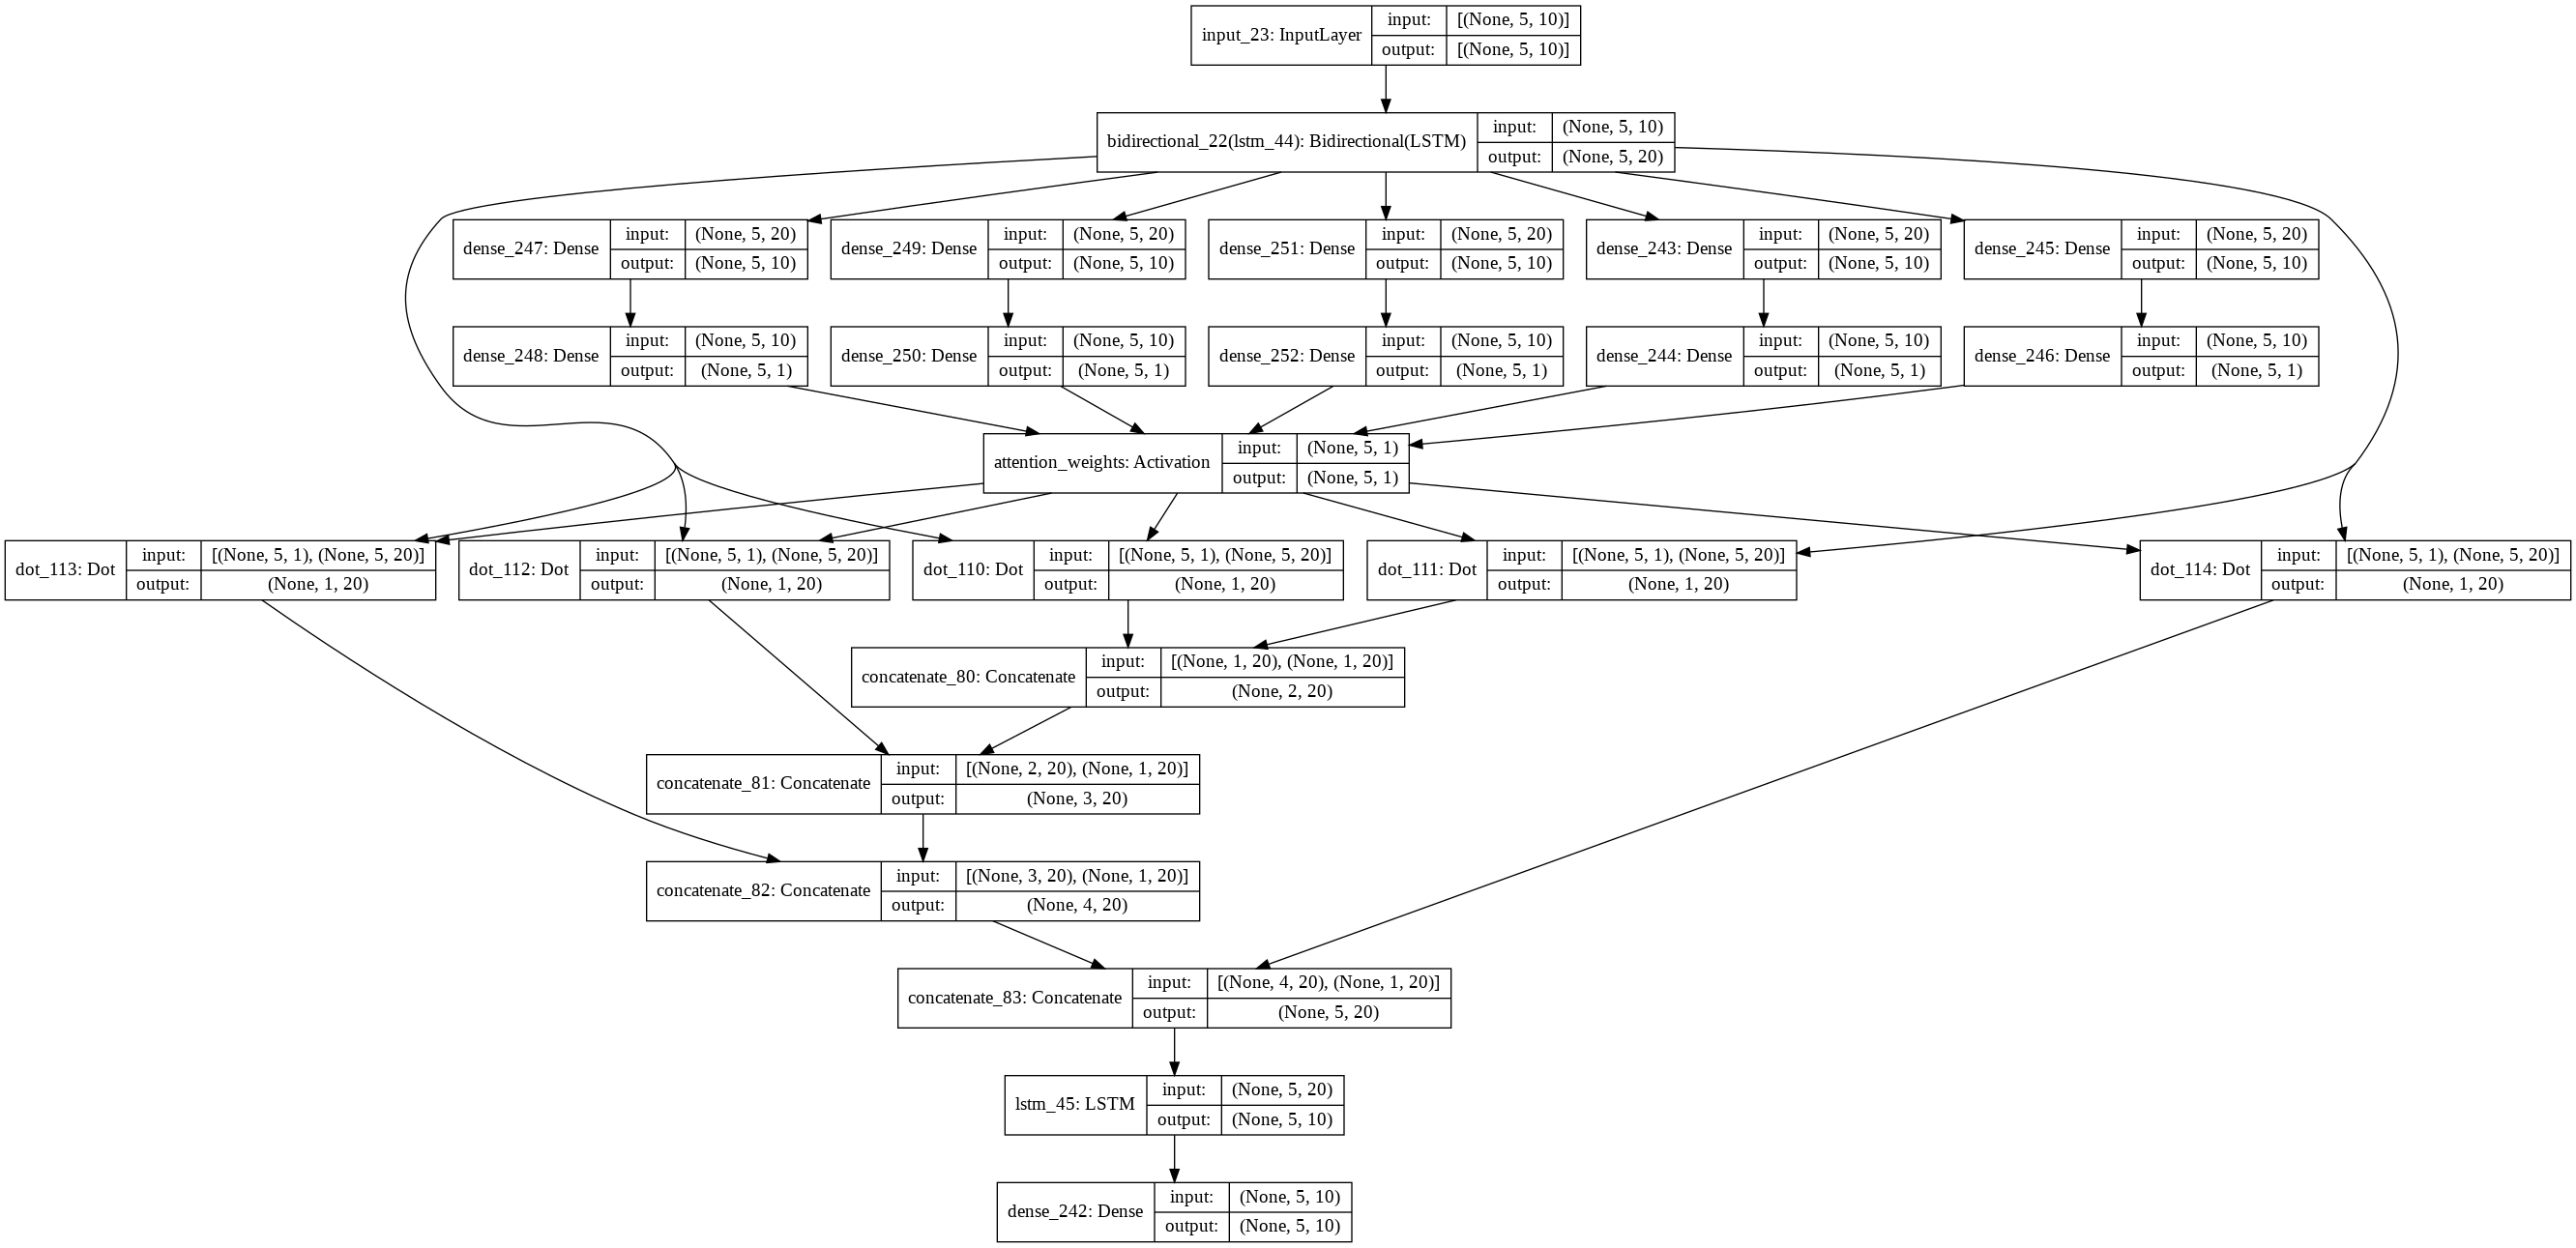

5. Check the accuracy of the attention model

In [6]:
# evaluate LSTM
total, correct = 100, 0

for _ in range(total):
    x,y = get_pair(n_timesteps_in,n_timesteps_out,n_features)
    yhat = attention_model.predict(x)
    if np.array_equal(one_hot_decode(y[0]), one_hot_decode(yhat[0])):
        correct += 1
print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Accuracy: 11.00%
